In [99]:
import hoomd
import numpy as np
import math

In [ ]:
class CentralWell(hoomd.md.force.Custom):
    """Custom force implementing a harmonic potential well at the centre of the box."""
    
    def __init__(self, k=1, r0=5.0):
        """
        Parameters:
        k (float): Spring constant for the harmonic well
        r0 (float): Radius at which the well starts acting
        """
        super().__init__(aniso=False)  # No torques needed
        self.k = k
        self.r0 = r0
    
    def set_forces(self, timestep):
        # Access particle positions and force arrays
        with self._state.cpu_local_snapshot as snap:
            with self.cpu_local_force_arrays as arrays:
                positions = snap.particles.position
                # Access box dimensions from the simulation state
                box = self._state.box
                box_dims = [box.Lx, box.Ly, box.Lz]
                
                # Get box centre (assuming box is centred at origin)
                centre = np.array([0.0, 0.0, 0.0])
                
                # Calculate distance from centre for each particle
                for i in range(len(positions)):
                    pos = positions[i]
                    # Calculate displacement from centre
                    dr = pos - centre
                    
                    # Apply minimum image convention for periodic boundaries
                    for dim in range(3):
                        if dr[dim] > box_dims[dim] * 0.5:
                            dr[dim] -= box_dims[dim]
                        elif dr[dim] < -box_dims[dim] * 0.5:
                            dr[dim] += box_dims[dim]
                    
                    # Distance from centre
                    r = np.linalg.norm(dr)
                    
                    # Apply harmonic restoring force only beyond r0
                    if r > self.r0:
                        # Harmonic potential: U = 0.5 * k * (r - r0)^2
                        # Force: F = -k * (r - r0) * (dr/r)
                        force_magnitude = +self.k * (r - self.r0)
                        if r > 0:  # Avoid division by zero
                            force_direction = dr / r
                            force = force_magnitude * force_direction
                            
                            arrays.force[i] += force
                            # Potential energy contribution
                            arrays.potential_energy[i] += 0.5 * self.k * (r - self.r0)**2

In [148]:
def create_simulation():
    """Create and configure the HOOMD-blue simulation."""
    
    # Initialize HOOMD
    device = hoomd.device.CPU()
    sim = hoomd.Simulation(device=device, seed=42)
    
    # Create simulation box with periodic boundary conditions
    box_size = 20.0
    spacing = 3
    
    # Create initial particle configuration
    # Simple cubic lattice
    N_particles_per_dim = int(box_size / spacing)
    
    # Calculate actual number of particles
    N = N_particles_per_dim**3
    
    # Create snapshot using proper HOOMD method
    snapshot = hoomd.Snapshot()
    snapshot.configuration.box = [box_size, box_size, box_size, 0, 0, 0]
    snapshot.particles.N = N
    snapshot.particles.types = ['A']
    
    # Create positions array
    positions = []
    for i in range(N):
        x = (i % N_particles_per_dim - N_particles_per_dim//2) * spacing
        y = ((i // N_particles_per_dim) % N_particles_per_dim - N_particles_per_dim//2) * spacing  
        z = (i // (N_particles_per_dim**2) - N_particles_per_dim//2) * spacing
        positions.append([x, y, z])
    
    snapshot.particles.position[:] = positions
    snapshot.particles.typeid[:] = [0] * N
    
    # Initialise simulation state
    sim.create_state_from_snapshot(snapshot)
    
    # Set up Lennard-Jones pair potential
    lj = hoomd.md.pair.LJ(nlist=hoomd.md.nlist.Cell(buffer=0.4))
    lj.params[('A', 'A')] = dict(epsilon=1.0, sigma=1.0)
    lj.r_cut[('A', 'A')] = 2.5
    
    # Set up central potential well
    central_well = CentralWell(k=2.0, r0=3.0)
    
    # Create integrator
    integrator = hoomd.md.Integrator(dt=0.005)
    
    # Add forces to integrator
    integrator.forces.append(lj)
    integrator.forces.append(central_well)
    
    # Set up NVT ensemble with Langevin thermostat
    nvt = hoomd.md.methods.Langevin(
        filter=hoomd.filter.All(),
        kT=1.0
    )
    integrator.methods.append(nvt)
    
    sim.operations.integrator = integrator
    
    # Set up simple GSD trajectory writer (no complex logging)
    gsd_writer = hoomd.write.GSD(
        filename='trajectory.gsd',
        trigger=hoomd.trigger.Periodic(100),
        mode='wb'
    )
    sim.operations.writers.append(gsd_writer)
    
    return sim


In [153]:
def run_simulation():
    """Run the simulation."""
    
    print("Setting up simulation...")
    sim = create_simulation()
    
    # Equilibration run
    print("Running equilibration...")
    sim.run(5000)
    
    # Production run
    print("Running production...")
    sim.run(50000)
    
    print("Simulation completed!")
    print("Output files:")
    print("  - trajectory.gsd: Particle positions and energies")
    print("  - energy.log: Energy data")

In [154]:
if __name__ == "__main__":
    run_simulation()

Setting up simulation...
Running equilibration...
Running production...
Simulation completed!
Output files:
  - trajectory.gsd: Particle positions and energies
  - energy.log: Energy data


In [143]:
# This is not intended as a full tutorial on fresnel - see the fresnel user
# documentation (https://fresnel.readthedocs.io/) if you would like to learn more.

import warnings

import fresnel
import IPython
import packaging.version

device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

FRESNEL_MIN_VERSION = packaging.version.parse("0.13.0")
FRESNEL_MAX_VERSION = packaging.version.parse("0.14.0")


def render(snapshot):
    if (
        "version" not in dir(fresnel)
        or packaging.version.parse(fresnel.version.version) < FRESNEL_MIN_VERSION
        or packaging.version.parse(fresnel.version.version) >= FRESNEL_MAX_VERSION
    ):
        warnings.warn(
            f"Unsupported fresnel version {fresnel.version.version} - expect errors."
        )
    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)
    geometry = fresnel.geometry.Sphere(
        scene, N=len(snapshot.particles.position), radius=0.5
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([252 / 255, 209 / 255, 1 / 255]), roughness=0.5
    )
    geometry.position[:] = snapshot.particles.position[:]
    geometry.outline_width = 0.04
    fresnel.geometry.Box(scene, [L, L, L, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(L * 2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    samples = 2000
    if "CI" in os.environ:
        samples = 100
    return IPython.display.Image(tracer.sample(scene, samples=samples)._repr_png_())

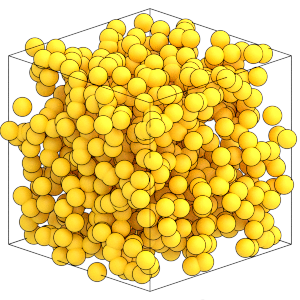

In [144]:
render(sim.state.get_snapshot())

Processing 550 frames...


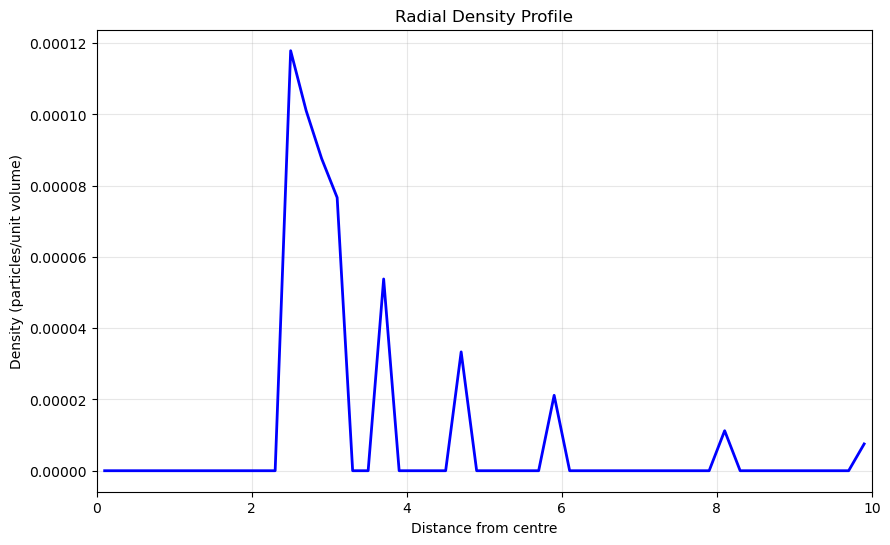

Analysed 540 frames
Maximum density: 0.000
Density at centre: 0.000
Density at edge: 0.000


In [156]:
def radial_density_profile(filename='trajectory.gsd', n_bins=50, skip_frames=10):
    """Calculate radial density profile from simulation centre."""
    
    # Open trajectory file
    traj = gsd.hoomd.open(filename, 'r')
    
    # Get box size from first frame
    frame = traj[0]
    box_size = frame.configuration.box[0]  # Assuming cubic box
    max_radius = box_size / 2.0
    
    # Create radial bins
    bin_edges = np.linspace(0, max_radius, n_bins + 1)
    bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]
    
    # Accumulate density over frames
    density_sum = np.zeros(n_bins)
    n_frames = 0
    
    print(f"Processing {len(traj)} frames...")
    
    # Skip initial frames for equilibration
    for frame in traj[skip_frames:]:
        positions = frame.particles.position
        
        # Calculate distances from centre (0,0,0)
        distances = np.sqrt(np.sum(positions**2, axis=1))
        
        # Create histogram
        hist, _ = np.histogram(distances, bins=bin_edges)
        
        # Convert to density (particles per unit volume)
        # Volume of spherical shell: 4π * r² * dr
        shell_volumes = 4 * np.pi * bin_centres**2 * bin_width
        # Avoid division by zero for r=0
        shell_volumes[0] = 4 * np.pi * bin_width**3 / 3  # Volume of sphere with r=bin_width
        
        density = hist / shell_volumes
        density_sum += density
        n_frames += 1
    
    # Average over frames
    avg_density = density_sum / n_frames
    
    # Plot results
    plt.figure(figsize=(10, 6))
    plt.plot(bin_centres, avg_density, 'b-', linewidth=2)
    plt.xlabel('Distance from centre')
    plt.ylabel('Density (particles/unit volume)')
    plt.title('Radial Density Profile')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, max_radius)
    plt.show()
    
    # Print some statistics
    print(f"Analysed {n_frames} frames")
    print(f"Maximum density: {np.max(avg_density):.3f}")
    print(f"Density at centre: {avg_density[0]:.3f}")
    print(f"Density at edge: {avg_density[-1]:.3f}")
    
    return bin_centres, avg_density

# Run the analysis
radii, density = radial_density_profile()